In [2]:
!pip install wget

  Using cached wget-3.2-py3-none-any.whl


In [3]:
from datetime import datetime,timedelta
import dateutil.parser
import os.path
import pathlib
import bisect
import csv
import warnings 
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import cdflib
import wget
import cdflib
import pandas as pd
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import ticker, cm


In [4]:
time_range = ['2021-04-29T00:00', '2021-04-30T00:00']
time_range = [dateutil.parser.parse(t_i) for t_i in time_range]

Find the fields data files, locally or online

In [5]:
fld_times = pd.date_range(time_range[0], time_range[1], freq='6H')
print(f'{fld_times=}')

fld_times=DatetimeIndex(['2021-04-29 00:00:00', '2021-04-29 06:00:00',
               '2021-04-29 12:00:00', '2021-04-29 18:00:00',
               '2021-04-30 00:00:00'],
              dtype='datetime64[ns]', freq='6H')


In [6]:
fld_paths = []

for fld_time in fld_times:
    fld_filename_glob = f'psp_fld_l2_mag_rtn_{fld_time:%Y%m%d%H}_v*.cdf'
    
    matched_local_files = list(pathlib.Path.cwd().glob(fld_filename_glob))
    if len(matched_local_files) == 0:
        # No local files found
        raise FileNotFoundError('{fld_filename_glob}')
        remote_dir = f'https://cdaweb.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/{fld_time:%Y}/'
        # This may not work because of the wildcard char in flt_filename_glob... You may need to specify the version numer instead of "*".
        # There is also no try-catch for wget in case the file does not exist online. Things to implement in the future if needed.
        fld_paths.append(wget.download(remote_dir + fld_filename_glob))
    else:
        fld_paths.append(matched_local_files[0])

print(f'FLD files found: {fld_paths}')

FileNotFoundError: {fld_filename_glob}

Load the ELD files

In [69]:
flt_cdf_files = []
mag_rtn = []
mag_times = []

for flt_path in flt_paths:
    _file_handle = cdflib.CDF(flt_path)
    flt_cdf_files.append(_file_handle)
    _epochs = np.array(cdflib.cdfepoch.to_datetime(_file_handle['epoch_mag_RTN']))
    idx = np.where(
        (_epochs >= time_range[0]) & 
        (_epochs < time_range[1])
    )[0]
    mag_rtn.append(_file_handle['psp_fld_l2_mag_RTN'][idx, :])
    mag_times.append(_epochs[idx])
    
mag_rtn=np.concatenate(mag_rtn)
mag_times = np.concatenate(mag_times)

In [70]:
mag_times

array([datetime.datetime(2021, 4, 29, 0, 0, 0, 1319),
       datetime.datetime(2021, 4, 29, 0, 0, 0, 4732),
       datetime.datetime(2021, 4, 29, 0, 0, 0, 8146), ...,
       datetime.datetime(2021, 4, 29, 4, 59, 59, 991419),
       datetime.datetime(2021, 4, 29, 4, 59, 59, 994833),
       datetime.datetime(2021, 4, 29, 4, 59, 59, 998246)], dtype=object)

In [4]:

    
#SPAN-Ion file
#
#Import from file directory
print(yyyymmdd(user_datetime))
file_spi_directoryRemote = f'https://cdaweb.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/{user_datetime.year:04d}/'
file_spi_filename = f'psp_swp_spi_sf00_l3_mom_{yyyymmdd(user_datetime)}_v04.cdf'

print(file_spi_directoryRemote + file_spi_filename)
#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(file_spi_filename):
    print(f"File already exists in local directory - [{file_spi_filename}]")
    file_spi = file_spi_filename
else:
    print("File doesn't exist. Downloading ...")
    file_spi = wget.download(file_spi_directoryRemote + file_spi_filename)
    
    

#SPAN-Electron file
PAfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spe/L3/spe_sf0_pad/{user_datetime.year:04d}/{user_datetime.month:02d}/'
PAfile_filename = f'psp_swp_spe_sf0_L3_pad_{yyyymmdd(user_datetime)}_v04.cdf'
print(PAfile_directoryRemote + PAfile_filename)
import os.path

#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(PAfile_filename):
    print (f"File already exists in local directory - [{PAfile_filename}]")
    PAfile = PAfile_filename
else:
    print ("File doesn't exist, downloading...")
    PAfile = wget.download(PAfile_directoryRemote + PAfile_filename)


#open span-e pitch angle CDF file
cdf_PAfile = cdflib.CDF(PAfile)
#define variables
eflux_vs_pitchAngle_vs_E = cdf_PAfile['EFLUX_VS_PA_E']
time_spe = cdf_PAfile['Epoch']
energy_vals_spe = cdf_PAfile['ENERGY_VALS']
pitchAngle = cdf_PAfile['PITCHANGLE']

#open span-i CDF file
cdf_file_spi = cdflib.CDF(file_spi)
#define variables
vel_rtn=cdf_file_spi['VEL_RTN_SUN']
vr=vel_rtn[:,0]
vt=vel_rtn[:,1]
vn=vel_rtn[:,2]
time_spi=cdf_file_spi['Epoch']
dens_spi=cdf_file_spi['DENS']
vel_inst=cdf_file_spi['VEL_INST']
vx=vel_inst[:,0]
vy=vel_inst[:,1]
vz=vel_inst[:,2]
eflux_vs_energy = cdf_file_spi['EFLUX_VS_ENERGY']
energy_vals_spi = cdf_file_spi['ENERGY_VALS']
mag_inst=cdf_file_spi['MAGF_INST']
bx=mag_inst[:,0]
by=mag_inst[:,1]
bz=mag_inst[:,2]

#open FIELDS CDF file
cdf_file_fld00 = cdflib.CDF(file_fld00)
cdf_file_fld06 = cdflib.CDF(file_fld06)
cdf_file_fld12 = cdflib.CDF(file_fld12)
cdf_file_fld18 = cdflib.CDF(file_fld18)
#define variables
mag_rtn00=cdf_file_fld00['psp_fld_l2_mag_RTN']
mag_rtn06=cdf_file_fld06['psp_fld_l2_mag_RTN']
mag_rtn12=cdf_file_fld12['psp_fld_l2_mag_RTN']
mag_rtn18=cdf_file_fld18['psp_fld_l2_mag_RTN']
mag_rtn=np.concatenate((mag_rtn00,mag_rtn06,mag_rtn12,mag_rtn18))

br=mag_rtn[:,0]
bt=mag_rtn[:,1]
bn=mag_rtn[:,2]
bmag=np.sqrt(br**2+bt**2+bn**2)
br_hat=br/bmag
bt_hat=bt/bmag
bn_hat=bn/bmag

20210429
File already exists in local directory - [psp_fld_l2_mag_rtn_2021042900_v02.cdf]
File already exists in local directory - [psp_fld_l2_mag_rtn_2021042906_v02.cdf]
File already exists in local directory - [psp_fld_l2_mag_rtn_2021042912_v02.cdf]
File already exists in local directory - [psp_fld_l2_mag_rtn_2021042918_v02.cdf]
20210429
https://cdaweb.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210429_v04.cdf
File already exists in local directory - [psp_swp_spi_sf00_l3_mom_20210429_v04.cdf]
http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spe/L3/spe_sf0_pad/2021/04/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
File already exists in local directory - [psp_swp_spe_sf0_L3_pad_20210429_v04.cdf]


In [6]:
#convert time
import datetime
datetime_t0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
epoch_fld00 = cdflib.cdfepoch.to_datetime(cdf_file_fld00.varget('epoch_mag_RTN'))
epoch_fld06 = cdflib.cdfepoch.to_datetime(cdf_file_fld06.varget('epoch_mag_RTN'))
epoch_fld12 = cdflib.cdfepoch.to_datetime(cdf_file_fld12.varget('epoch_mag_RTN'))
epoch_fld18 = cdflib.cdfepoch.to_datetime(cdf_file_fld18.varget('epoch_mag_RTN'))
epoch_fld=np.concatenate((epoch_fld00,epoch_fld06,epoch_fld12,epoch_fld18))
epoch_spe = cdflib.cdfepoch.to_datetime(cdf_PAfile.varget('Epoch'))
epoch_spi = cdflib.cdfepoch.to_datetime(cdf_file_spi.varget('Epoch'))

In [8]:
T_Tens = cdf_file_spi['T_TENSOR_INST']
print(T_Tens.shape)
T_XX = T_Tens[:,0]
T_YY = T_Tens[:,1]
T_ZZ = T_Tens[:,2]
T_XY = T_Tens[:,3]
T_XZ = T_Tens[:,4]
T_YZ = T_Tens[:,5]

T_YX = T_XY
T_ZX = T_XZ
T_ZY = T_YZ

B_spi = cdf_file_spi['MAGF_INST']
B_X = B_spi[:,0]
B_Y = B_spi[:,1]
B_Z = B_spi[:,2]
B_mag_XYZ = np.sqrt(B_X**2 + B_Y**2 + B_Z**2)

T_parallel=[]
T_perpendicular=[]
Anisotropy=[]
for i in range(len(B_X)):
    Sum_1=B_X[i]*B_X[i]*T_XX[i]
    Sum_2=B_X[i]*B_Y[i]*T_XY[i]
    Sum_3=B_X[i]*B_Z[i]*T_XZ[i]
    Sum_4=B_Y[i]*B_X[i]*T_YX[i]
    Sum_5=B_Y[i]*B_Y[i]*T_YY[i]
    Sum_6=B_Y[i]*B_Z[i]*T_YZ[i]
    Sum_7=B_Z[i]*B_X[i]*T_ZX[i]
    Sum_8=B_Z[i]*B_Y[i]*T_ZY[i]
    Sum_9=B_Z[i]*B_Z[i]*T_ZZ[i]    
    T_para=((Sum_1+Sum_2+Sum_3+Sum_4+Sum_5+Sum_6+Sum_7+Sum_8+Sum_9)/(B_mag_XYZ[i])**2)
    Trace_Temp=(T_XX[i]+T_YY[i]+T_ZZ[i])
    T_perp=(Trace_Temp-T_para)/2.0
    T_parallel.append((Sum_1+Sum_2+Sum_3+Sum_4+Sum_5+Sum_6+Sum_7+Sum_8+Sum_9)/(B_mag_XYZ[i])**2)
    T_perpendicular.append(T_perp)
    Anisotropy.append(T_perp/T_para)

(24704, 6)


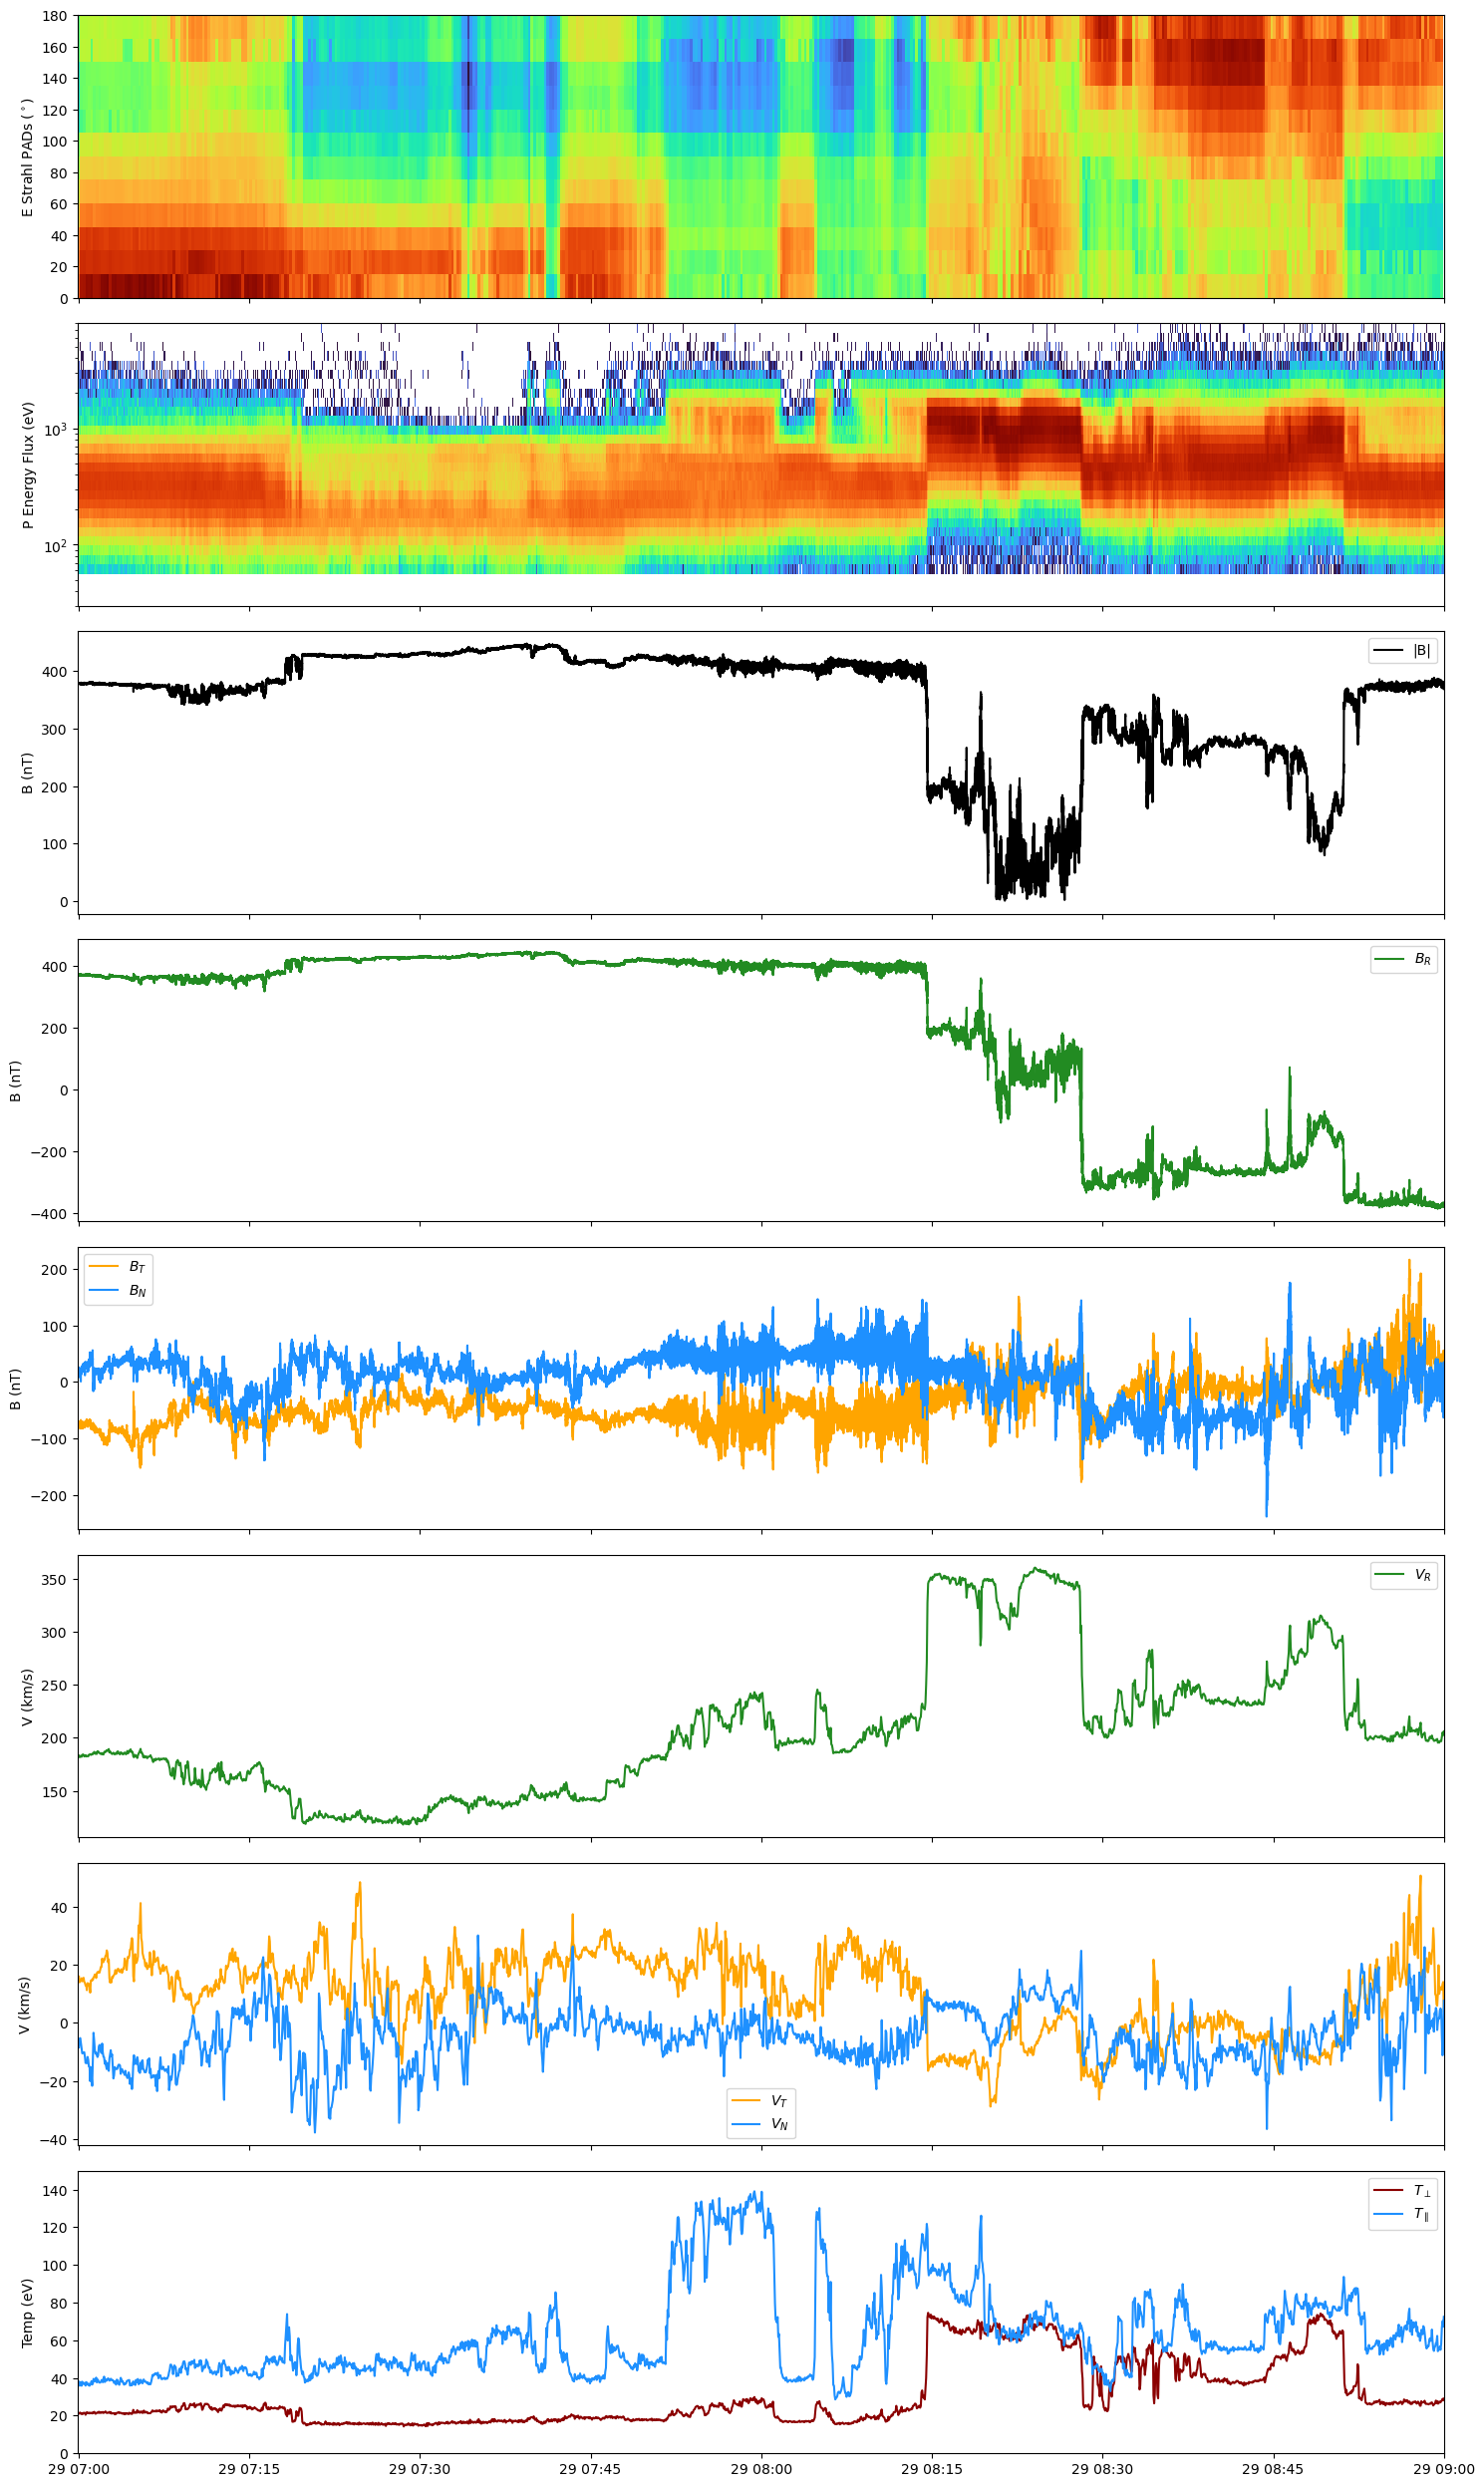

In [14]:
energyIndex=8
tSliceIndex_start_spi,tSliceIndex_stop_spi,tSliceIndex_start_fld,tSliceIndex_stop_fld,tSliceIndex_start_spe,tSliceIndex_stop_spe=convert_time(7,0,0,9,0,0)
epoch_spe_repeat_ = np.repeat(np.expand_dims(epoch_spe[tSliceIndex_start_spe:tSliceIndex_stop_spe],1),12,1)
epoch_spi_repeat_ = np.repeat(np.expand_dims(epoch_spi[tSliceIndex_start_spi:tSliceIndex_stop_spi],1),32,1)

fig, ax = plt.subplots(8, 1, sharex=True, figsize=(15, 25))

s=ax[0].pcolormesh(epoch_spe_repeat_,pitchAngle[tSliceIndex_start_spe:tSliceIndex_stop_spe],
         np.log10(eflux_vs_pitchAngle_vs_E[tSliceIndex_start_spe:tSliceIndex_stop_spe,:,energyIndex]),cmap='turbo')
#cbar = plt.colorbar(s,label=f'Electron Flux ($eV/(cm^2 \\ s \\ sr \\ eV)$)')
s2=ax[1].pcolormesh(epoch_spi_repeat_,energy_vals_spi[tSliceIndex_start_spi:tSliceIndex_stop_spi],
         np.log10(eflux_vs_energy[tSliceIndex_start_spi:tSliceIndex_stop_spi,:]),cmap='turbo')

zipped_obj = zip(
    [bmag, br, bt, bn], 
    ['|B|', '$B_R$', '$B_T$', '$B_N$'], 
    ['k', 'forestgreen', 'orange', 'dodgerblue'],
    [2, 3, 4, 4]
)
for y_i, label, color, ax_index in zipped_obj:
    ax[ax_index].plot(epoch_fld, y_i, label=label, color=color)
                                        
ax[5].plot(epoch_spi[tSliceIndex_start_spi:tSliceIndex_stop_spi], vr[tSliceIndex_start_spi:tSliceIndex_stop_spi],label='$V_R$',color='forestgreen')
ax[6].plot(epoch_spi[tSliceIndex_start_spi:tSliceIndex_stop_spi], vt[tSliceIndex_start_spi:tSliceIndex_stop_spi],label='$V_T$',color='orange')
ax[6].plot(epoch_spi[tSliceIndex_start_spi:tSliceIndex_stop_spi], vn[tSliceIndex_start_spi:tSliceIndex_stop_spi],label='$V_N$',color='dodgerblue')
ax[7].plot(epoch_spi[tSliceIndex_start_spi:tSliceIndex_stop_spi],T_perpendicular[tSliceIndex_start_spi:tSliceIndex_stop_spi],label='$T_\perp$',color='darkred')
ax[7].plot(epoch_spi[tSliceIndex_start_spi:tSliceIndex_stop_spi],T_parallel[tSliceIndex_start_spi:tSliceIndex_stop_spi],label='$T_\parallel$',color='dodgerblue')

ax[0].set(
    ylabel=f'E Strahl PADs $(^\circ)$',
)
ax[1].set(
    ylabel=f'P Energy Flux (eV)',
    ylim=[30,8e3]
)

ax[7].set(
    ylabel=f'N ($cm^{-3}$)',
    ylim=[0,10000]
    #ylim=[2300,3000]

)


ax[7].set(
    ylabel=f'Temp (eV)',
    ylim=[0,150]
)

ax[2].set(ylabel=f'B (nT)', xlim=(datetime(2021, 4, 29, 2), datetime(2021, 4, 29, 5)))
ax[3].set(ylabel=f'B (nT)')
ax[4].set(ylabel=f'B (nT)')
ax[5].set(ylabel=f'V (km/s)')
ax[6].set(ylabel=f'V (km/s)')
ax[1].set_yscale('log')

ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()

plt.tight_layout()

tname=f"{epoch_spi[tSliceIndex_start_spi].strftime('%y%m%d_%H%M%S')}"+'-'+f"{epoch_spi[tSliceIndex_stop_spi].strftime('%H%M%S')}"
#drname = '/home/jovyan/e8_figs/'
#fname = '_b_v_pad_pnrg_p_nlfr_tempanis.png'
#plt.savefig(drname+tname+fname)         
plt.show()